Epoch 1/5
422/422 [==============================] - 13s 28ms/step - loss: 0.2243 - accuracy: 0.9363 - val_loss: 0.0602 - val_accuracy: 0.9815
Epoch 2/5
422/422 [==============================] - 11s 27ms/step - loss: 0.0589 - accuracy: 0.9817 - val_loss: 0.0426 - val_accuracy: 0.9885
Epoch 3/5
422/422 [==============================] - 11s 27ms/step - loss: 0.0413 - accuracy: 0.9871 - val_loss: 0.0542 - val_accuracy: 0.9833
Epoch 4/5
422/422 [==============================] - 11s 27ms/step - loss: 0.0319 - accuracy: 0.9902 - val_loss: 0.0440 - val_accuracy: 0.9865
Epoch 5/5
422/422 [==============================] - 11s 27ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.0297 - val_accuracy: 0.9913


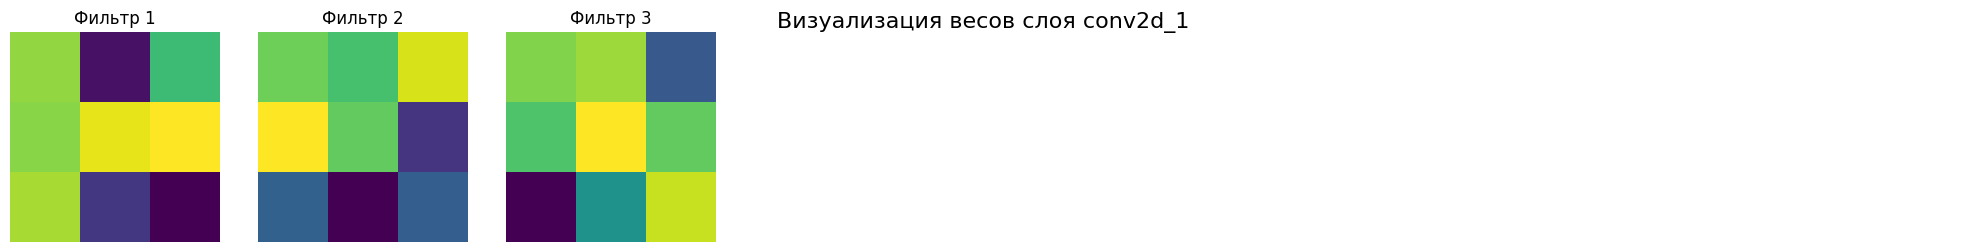

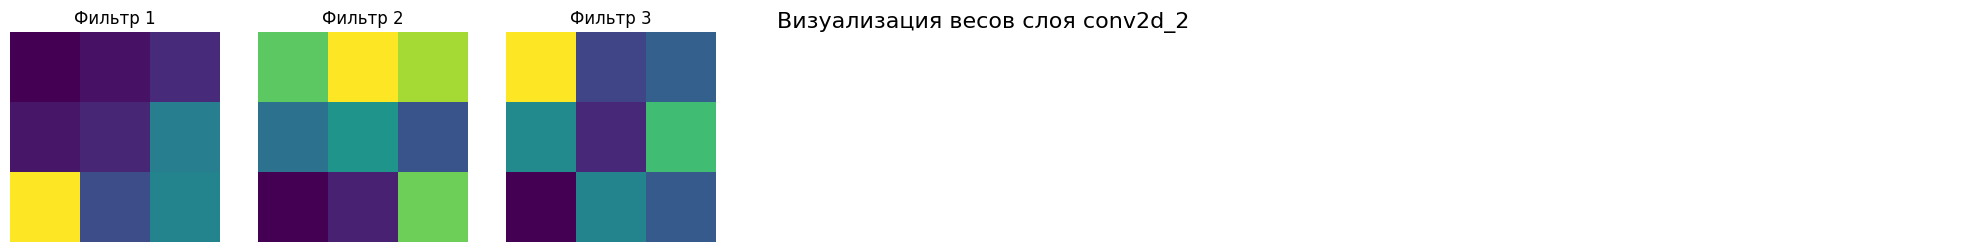

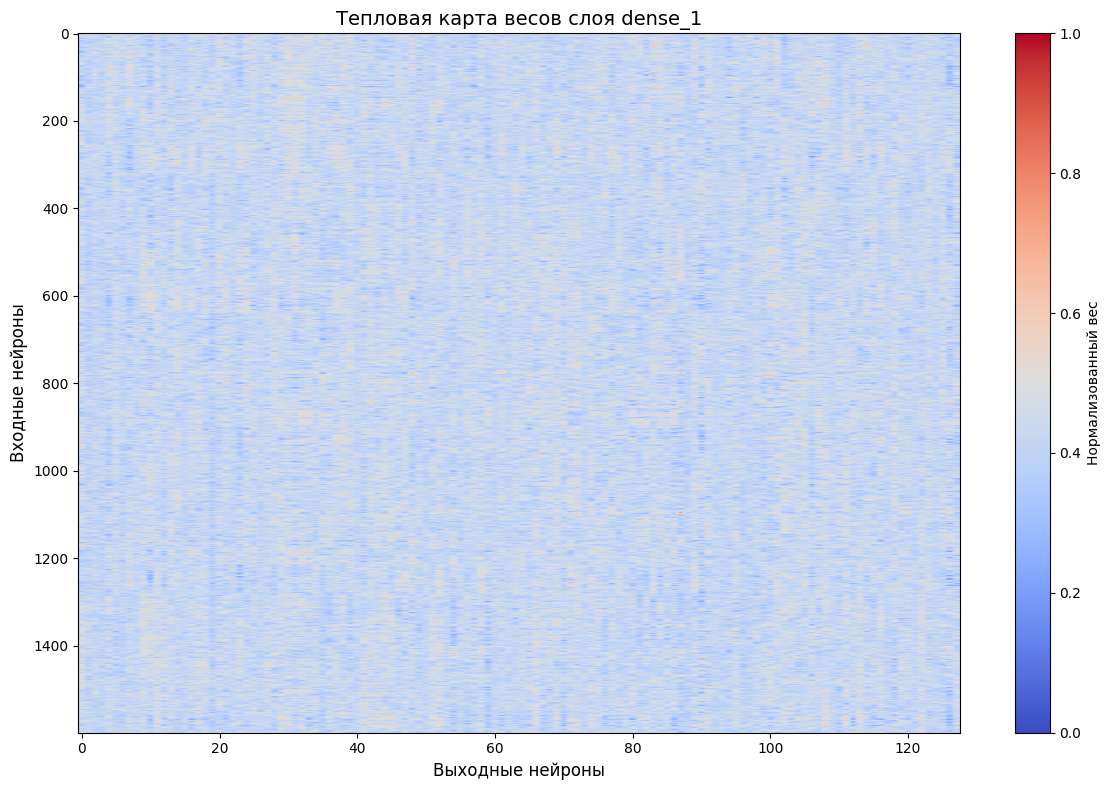

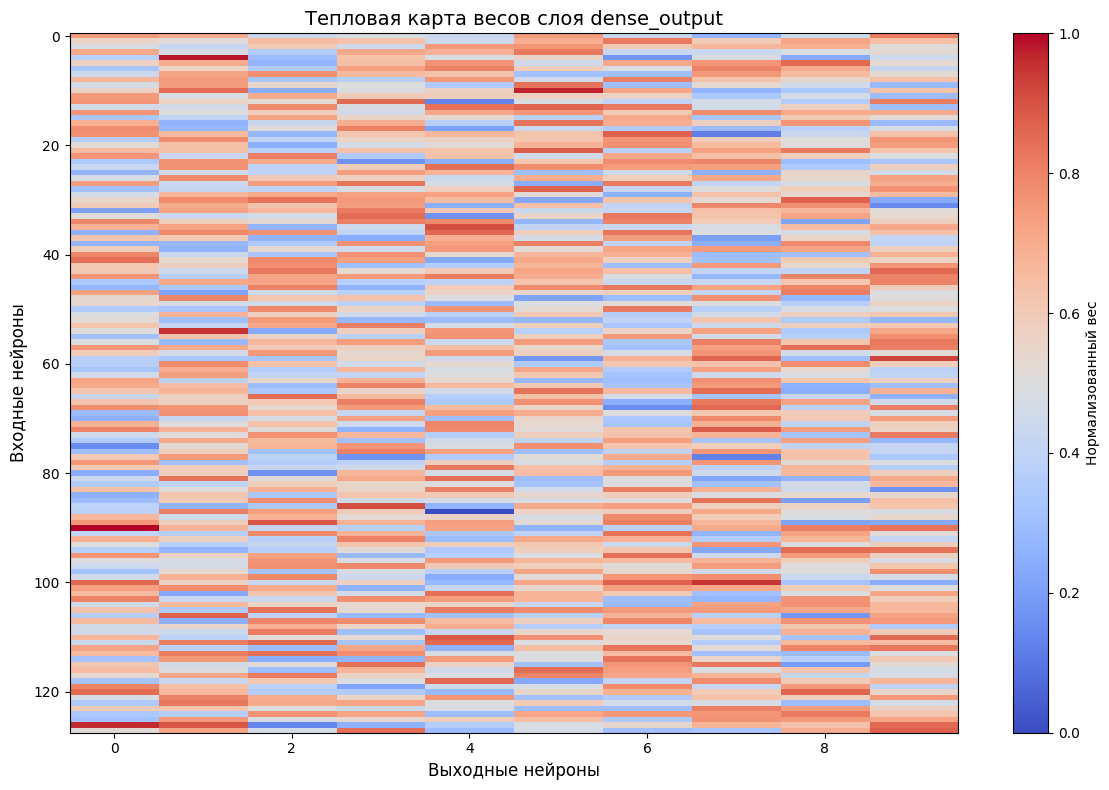

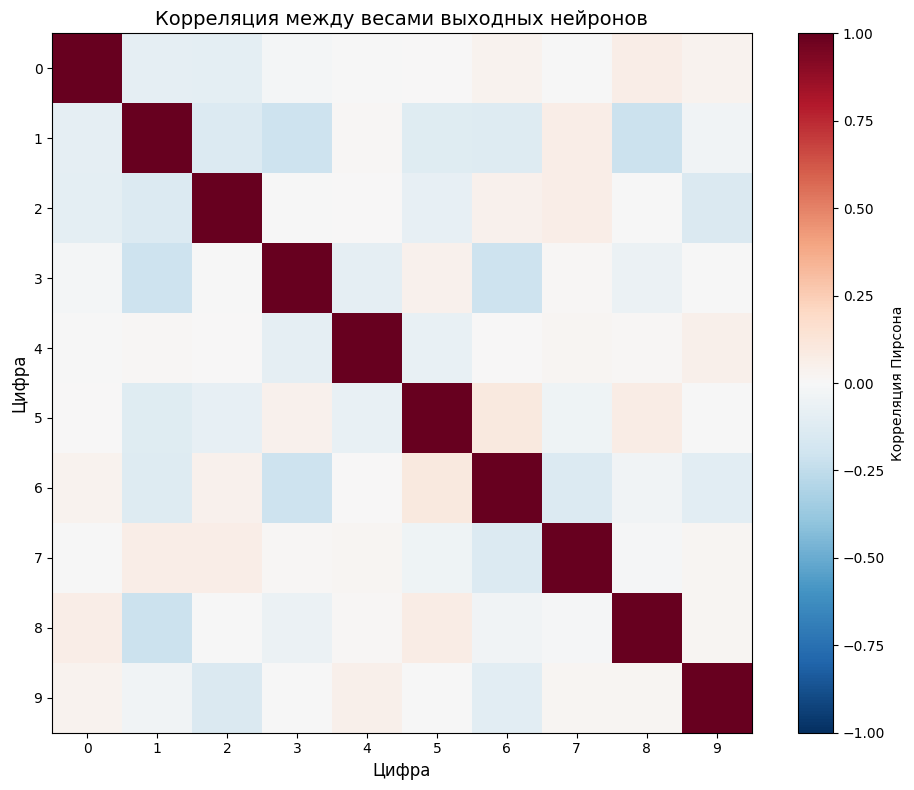

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Загрузка и подготовка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Создание и обучение простой CNN для MNIST
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1, verbose=1)

# Функция для визуализации весов сверточных слоев
def visualize_conv_weights(model, layer_name):
    # Получаем веса указанного сверточного слоя
    layer = model.get_layer(name=layer_name)
    weights = layer.get_weights()[0]
    
    # Нормализация весов для визуализации
    weights_min = weights.min()
    weights_max = weights.max()
    weights_norm = (weights - weights_min) / (weights_max - weights_min)
    
    # Получаем размерность весов
    if len(weights.shape) == 4:  # Conv2D
        n_filters, n_channels, filter_height, filter_width = weights.shape
    else:
        n_filters, filter_height, filter_width, n_channels = weights.shape
    
    # Создаем сетку для визуализации фильтров
    n_cols = 8
    n_rows = int(np.ceil(n_filters / n_cols))
    
    # Размеры изображения для отображения одного фильтра
    fig_width = 20
    fig_height = fig_width * n_rows / n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axes = axes.flatten()
    
    # Отображаем каждый фильтр
    for i in range(n_filters):
        if i < n_filters:
            # Для первого сверточного слоя мы можем визуализировать фильтры напрямую
            if n_channels == 1:
                img = weights_norm[:, :, :, i].reshape(filter_height, filter_width)
            else:
                # Для RGB создаем цветное изображение или берем среднее по каналам
                img = np.mean(weights_norm[:, :, :, i], axis=2)
            
            axes[i].imshow(img, cmap='viridis')
            axes[i].set_title(f'Фильтр {i+1}')
            axes[i].axis('off')
    
    # Скрываем оси для неиспользуемых ячеек
    for i in range(n_filters, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Визуализация весов слоя {layer_name}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Функция для визуализации весов полносвязных слоев
def visualize_dense_weights(model, layer_name, input_shape=None):
    # Получаем веса указанного полносвязного слоя
    layer = model.get_layer(name=layer_name)
    weights = layer.get_weights()[0]  # [входные_нейроны, выходные_нейроны]
    
    # Нормализация весов для визуализации
    weights_min = weights.min()
    weights_max = weights.max()
    weights_norm = (weights - weights_min) / (weights_max - weights_min)
    
    # Если форма входных данных известна (например, после Flatten из изображения)
    if input_shape:
        height, width = input_shape
        
        # Визуализируем веса как изображения (для первого Dense после сверточных слоев)
        fig, axes = plt.subplots(4, 4, figsize=(12, 12))
        axes = axes.flatten()
        
        for i in range(min(16, weights.shape[1])):  # Отображаем первые 16 нейронов
            weight_img = weights[:, i].reshape(height, width)
            axes[i].imshow(weight_img, cmap='viridis')
            axes[i].set_title(f'Нейрон {i+1}')
            axes[i].axis('off')
        
        plt.suptitle(f'Визуализация весов для первых 16 нейронов слоя {layer_name}', fontsize=14)
    else:
        # Для обычных полносвязных слоев визуализируем тепловую карту весов
        plt.figure(figsize=(12, 8))
        plt.imshow(weights_norm, cmap='coolwarm', aspect='auto')
        plt.colorbar(label='Нормализованный вес')
        plt.title(f'Тепловая карта весов слоя {layer_name}', fontsize=14)
        plt.xlabel('Выходные нейроны', fontsize=12)
        plt.ylabel('Входные нейроны', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Назначаем имена слоям для удобства визуализации
model.layers[0]._name = 'conv2d_1'
model.layers[2]._name = 'conv2d_2'
model.layers[4]._name = 'flatten'
model.layers[5]._name = 'dense_1'
model.layers[6]._name = 'dense_output'

# Визуализация весов первого сверточного слоя
visualize_conv_weights(model, 'conv2d_1')

# Визуализация весов второго сверточного слоя
visualize_conv_weights(model, 'conv2d_2')

# Визуализация весов первого полносвязного слоя
# Предполагаем, что входные данные для dense_1 после сверточных слоев имеют определенную форму
# Необходимо вычислить эту форму
feature_map_shape = model.get_layer('flatten').output_shape[1]
visualize_dense_weights(model, 'dense_1')

# Визуализация весов выходного слоя
visualize_dense_weights(model, 'dense_output')

# Визуализация корреляции между весами выходного слоя
plt.figure(figsize=(10, 8))
output_weights = model.get_layer('dense_output').get_weights()[0]
correlation_matrix = np.corrcoef(output_weights.T)
plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Корреляция Пирсона')
plt.title('Корреляция между весами выходных нейронов', fontsize=14)
plt.xticks(range(10), range(10))
plt.yticks(range(10), range(10))
plt.xlabel('Цифра', fontsize=12)
plt.ylabel('Цифра', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()
